<a href="https://colab.research.google.com/github/sooyeon-go/recipe_rating/blob/master/preprocessing/20200205_hrson(lr%3D0.001%20%26%20batchsize%3D256%20%26%20Dropout(0.5)).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 40kB/s 
     |████████████████████████████████| 3.8MB 46.7MB/s 
     |████████████████████████████████| 450kB 66.8MB/s 
     |████████████████████████████████| 81kB 14.5MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found exis

In [1]:
import tensorflow
tensorflow.__version__

'2.0.0'

In [2]:
import pandas as pd
import random
import re
from nltk.tokenize import word_tokenize, sent_tokenize
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# review_rating data EDA

In [0]:
review_rating = pd.read_csv('/content/drive/My Drive/review_rating.csv')

In [5]:
review_rating = review_rating.astype({'rating': 'category'})
review_rating.head()

,review,rating
0,Great with a salad. Cooked on top of stove for...,4
1,This worked very well and is EASY. I used not...,4
2,very very sweet. after i waited the 2 days i b...,4
3,This recipe was OVERLY too sweet. I would sta...,2
4,Very good!,4


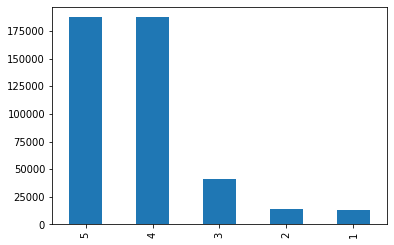

In [6]:
review_rating['rating'].value_counts().plot(kind='bar')

In [7]:
print(review_rating.groupby('rating').size().reset_index(name='count'))

  rating   count
0      1   12815
1      2   14122
2      3   40852
3      4  187333
4      5  187333


In [8]:
review_rating.isnull().values.any()

False

In [9]:
review_rating.drop_duplicates(inplace=True)
review_rating.duplicated().sum()

0

In [10]:
print(review_rating.groupby('rating').size().reset_index(name='count'))

  rating   count
0      1   12784
1      2   14113
2      3   40786
3      4  186723
4      5  186512


In [11]:
len(review_rating)

440918

In [12]:
review_rating['review'] = review_rating['review'].str.replace("[^a-zA-Z ]", '')
review_rating.head()

,review,rating
0,Great with a salad Cooked on top of stove for ...,4
1,This worked very well and is EASY I used not ...,4
2,very very sweet after i waited the days i bou...,4
3,This recipe was OVERLY too sweet I would star...,2
4,Very good,4


In [13]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
from nltk.corpus import stopwords  
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [0]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

sentences = []
stop_words = set(stopwords.words('english')) 

for i in review_rating['review']:
    sentence = word_tokenize(i)
    result = []
    
    for word in sentence:
        word = word.lower() # 모든 단어를 소문자화하여 단어의 개수를 줄입니다.
        if word not in stop_words:
            if len(word) > 2:
                result.append(word)
    sentences.append(result)

In [16]:
print(sentences[:5])

[['great', 'salad', 'cooked', 'top', 'stove', 'minutesadded', 'shake', 'cayenne', 'pinch', 'salt', 'used', 'low', 'fat', 'sour', 'cream', 'thanks'], ['worked', 'well', 'easy', 'used', 'quite', 'whole', 'package', 'white', 'chips', 'great'], ['sweet', 'waited', 'days', 'bought', 'pints', 'raspberries', 'added', 'mix', 'going', 'add', 'cake', 'filling', 'today', 'take', 'photo'], ['recipe', 'overly', 'sweet', 'would', 'start', 'cup', 'sugar', 'jsut', 'add', 'cups', 'way', 'much', 'back', 'grocery', 'store', 'buy', 'raspberries', 'made', 'much', 'mix', 'overall', 'would', 'long', 'narrow', 'box', 'raspberries', 'perfect', 'fit', 'recipe', 'plus', 'little', 'extra', 'impressed', 'recipe', 'exceptionally', 'oversweet', 'make', 'simple', 'recipe', 'make', 'sure', 'add', 'less', 'sugar'], ['good']]


In [0]:
max_words = 35000
tokenizer = Tokenizer(num_words=max_words) # 상위 35,000개의 단어만 보존
tokenizer.fit_on_texts(sentences)
review_data = tokenizer.texts_to_sequences(sentences)

In [18]:
print(review_data[:5])

[[7, 97, 65, 85, 721, 1699, 446, 790, 71, 3, 216, 187, 209, 43, 6], [188, 33, 12, 3, 112, 96, 907, 169, 240, 7], [50, 2241, 577, 515, 3210, 1401, 10, 109, 173, 23, 75, 179, 359, 277, 629], [1, 1043, 50, 13, 658, 55, 36, 10209, 23, 210, 47, 22, 171, 1164, 432, 622, 1401, 2, 22, 109, 402, 13, 250, 8125, 745, 1401, 77, 832, 1, 537, 15, 104, 915, 1, 3917, 12010, 5, 107, 1, 5, 78, 23, 140, 36], [4]]


리뷰의 최대 길이 : 619
리뷰의 평균 길이 : 26.45106573104296


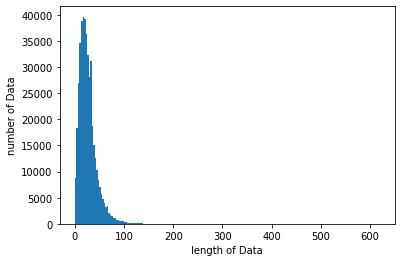

In [19]:
print('리뷰의 최대 길이 :',max(len(l) for l in review_data))
print('리뷰의 평균 길이 :',sum(map(len, review_data))/len(review_data))
plt.hist([len(s) for s in review_data], bins=200)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [0]:
max_len = 60 # 전체 데이터의 길이는 60으로 맞춘다.
review_data = pad_sequences(review_data, maxlen=max_len)

In [0]:
rating_data = np.array(review_rating['rating'])

# Fasttext

In [22]:
from __future__ import print_function
from gensim.models import KeyedVectors

# Creating the model
eng_model = KeyedVectors.load_word2vec_format('/content/drive/My Drive/wiki.en.vec')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# Getting the tokens 
words = []
for word in eng_model.vocab:
    words.append(word)

In [24]:
# Printing out number of tokens available
print("Number of Tokens: {}".format(len(words)))

Number of Tokens: 2519370


In [25]:
# Printing out the dimension of a word vector 
print("Dimension of a word vector: {}".format(
    len(eng_model[words[0]])
))

Dimension of a word vector: 300


In [26]:
# Print out the vector of a word 
print("Vector components of a word: {}".format(
    eng_model[words[0]]
))

Vector components of a word: [-2.3167e-02 -4.2483e-03 -1.0572e-01  4.2783e-02 -1.4316e-01 -7.8954e-02
  7.8187e-02 -1.9454e-01  2.2303e-02  3.1207e-01  5.7462e-02 -1.1589e-01
  9.6633e-02 -9.3229e-02 -3.4229e-02 -1.4652e-01 -1.1094e-01 -1.1102e-01
  6.7728e-02  1.0023e-01 -6.7413e-02  2.3761e-01 -1.3105e-01 -8.3979e-03
 -1.0593e-01  2.4526e-01  6.5903e-02 -2.3740e-01 -1.0758e-01  5.7082e-03
 -8.1413e-02  2.6264e-01 -5.2461e-02  2.0306e-01  5.0620e-02 -1.8866e-01
 -1.1494e-01 -2.5752e-01  4.6799e-02 -5.0525e-02  6.2650e-02  1.5433e-01
 -5.6289e-02 -4.8437e-02 -9.9688e-02 -3.5332e-02 -9.1647e-02 -8.1151e-02
 -1.0844e-03 -8.4140e-02 -1.3026e-01  1.4980e-02 -8.6276e-02 -5.3041e-02
 -1.0644e-01 -4.2314e-02  8.6469e-02  2.2614e-01 -1.6078e-01  1.8845e-01
  5.3098e-02 -2.1475e-01  1.6699e-01 -1.4442e-01 -1.5930e-01  6.2456e-03
 -7.6630e-02 -9.1568e-02 -2.8984e-01  2.7078e-02  2.1275e-02  2.3939e-02
  1.4903e-01 -3.3062e-01 -9.7811e-02 -3.3814e-02  7.0587e-02  2.3294e-02
  6.5382e-02  1.8716e-

In [27]:
print(words[0])

,


In [28]:
words[50]

'you'

In [0]:
embedding_dict = dict()
for word in words:
    embedding_dict[word] = eng_model[word]

In [30]:
vocab_size = len(tokenizer.word_index.items()) + 1
embedding_matrix = np.zeros((vocab_size, 300))
# 단어 집합 크기의 행과 100개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
np.shape(embedding_matrix)

(164480, 300)

In [0]:
for word, i in tokenizer.word_index.items(): # 훈련 데이터의 단어 집합에서 단어를 1개씩 꺼내온다.
    temp = embedding_dict.get(word) # 단어(key) 해당되는 임베딩 벡터의 300개의 값(value)를 임시 변수에 저장
    if temp is not None:
        embedding_matrix[i] = temp # 임수 변수의 값을 단어와 맵핑되는 인덱스의 행에 삽입

In [32]:
embedding_matrix.shape

(164480, 300)

In [33]:
rating_data

array([4, 4, 4, ..., 5, 5, 5])

In [0]:
rating_data = to_categorical(rating_data)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(review_data, rating_data, test_size=0.1, random_state=0, stratify=rating_data)

In [36]:
x_train.shape,x_test.shape, y_train.shape, y_test.shape

((396826, 60), (44092, 60), (396826, 6), (44092, 6))

# 1. LSTM으로 리뷰 점수 분석 (lr=0.001)

In [0]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [0]:
from keras import backend as K

def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_len, trainable=False)
model.add(e)
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

adam = Adam(learning_rate=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', f1_m])

In [41]:
history = model.fit(x_train, y_train, epochs=10, batch_size=256, validation_data=(x_test, y_test))

Train on 396826 samples, validate on 44092 samples
Epoch 1/10
396826/396826 [==============================] - 141s 356us/sample - loss: 0.8603 - accuracy: 0.6263 - f1_m: 0.5971 - val_loss: 0.7920 - val_accuracy: 0.6495 - val_f1_m: 0.6310
Epoch 2/10
396826/396826 [==============================] - 133s 336us/sample - loss: 0.7804 - accuracy: 0.6597 - f1_m: 0.6429 - val_loss: 0.7650 - val_accuracy: 0.6607 - val_f1_m: 0.6494
Epoch 3/10
396826/396826 [==============================] - 134s 337us/sample - loss: 0.7564 - accuracy: 0.6692 - f1_m: 0.6549 - val_loss: 0.7491 - val_accuracy: 0.6702 - val_f1_m: 0.6578
Epoch 4/10
396826/396826 [==============================] - 134s 337us/sample - loss: 0.7407 - accuracy: 0.6763 - f1_m: 0.6638 - val_loss: 0.7406 - val_accuracy: 0.6751 - val_f1_m: 0.6645
Epoch 5/10
396826/396826 [==============================] - 134s 337us/sample - loss: 0.7291 - accuracy: 0.6817 - f1_m: 0.6694 - val_loss: 0.7339 - val_accuracy: 0.6772 - val_f1_m: 0.6674
Epoch 6/1

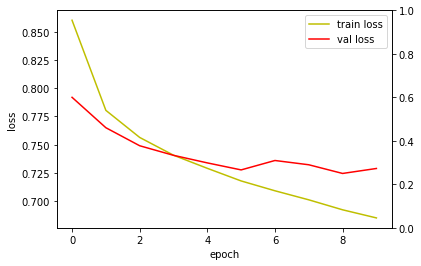

In [42]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

plt.show()

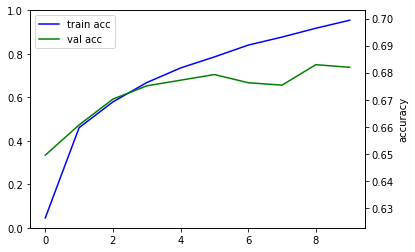

In [43]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()